In [20]:
## Import libraries
#general
import pandas as pd
import os
import numpy as np
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
import re
from sklearn.externals.six import StringIO


#visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [13]:
## Read in data
data = pd.read_csv('monster_com-job_sample.csv')
data.columns

Index([u'country', u'country_code', u'date_added', u'has_expired',
       u'job_board', u'job_description', u'job_title', u'job_type',
       u'location', u'organization', u'page_url', u'salary', u'sector',
       u'uniq_id'],
      dtype='object')

In [14]:
## Parse salary data and prepare dataset
#data['numbers']=''
data['yearly'] = ''
data['hourly'] =''
data['full_time']=''
data['part_time']=''
data['analyst']=''

for index in data.salary.index:

    #data['numbers'][index]=bool(re.match(r'([0-9]+[^0-9]+)',str(data.salary[index])))
    data['yearly'][index]=bool(re.search('\$ /year',str(data.salary[index])))
    data['hourly'][index]=bool(re.search('\$ /hour',str(data.salary[index])))
    data['full_time'][index]=bool(re.search('Full Time',str(data.job_type[index])))
    data['part_time'][index]=bool(re.search('(part)|(Part)',str(data.job_type[index])))
    data['analyst'][index]=bool(re.search('(analyst)|(Analyst)',str(data.job_title[index])))

#extract salary ranges
ranges=data.salary.str.extract(r'([0-9\.\,\s]+.\-[0-9\.\,\s]+)',expand=True).rename(columns={0:'ranges'})
data=data.join(ranges)

#extract numbers
numbers=data.salary.str.extract(r'([0-9]+\s)',expand=True,).rename(columns={0:'numbers'})
data=data.join(numbers)

#parse salary ranges
df=data['ranges'].str.split('-',expand=True).rename(columns={0:'lowest',1:'highest'})
data=data.join(df)

#convert columns to numeric
numeric=pd.Index([u'lowest',u'highest',u'numbers'])

for i in numeric:
    data[i]=data[i].str.replace(' ','')
    data[i]=data[i].str.replace(',','')
    data[i]=pd.to_numeric(data[i])





KeyboardInterrupt: 

In [269]:
#convert units of hours into units of years
for index in data.salary.index:
        for i in numeric:
            if (data.hourly[index]==True):
                if(data.part_time[index]==False):
                    data[i][index]=data[i][index]*40*52
                else:
                   data[i][index]=data[i][index]*20*52

C:\Users\daherg\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\daherg\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: 

In [2]:
#get midpoint data for ranges
data['midpoint_salary']=(data['lowest']+data['highest'])/2

#add non-range salaries to midpoints column
for index in data.salary.index:
    if(pd.isnull(data.ranges[index])&pd.notnull(data.numbers[index])):
        data.midpoint_salary[index]=data.numbers[index]

NameError: name 'data' is not defined

In [2]:
#write cleaned data to csv
#data.to_csv('monster_com-job_sample_cleaned.csv')

NameError: name 'data' is not defined

In [15]:
data=pd.read_csv('monster_com-job_sample_cleaned.csv')
#remove nan's
data=data.dropna(subset=['midpoint_salary'])

#only yearly and hourly salary
data=data[data.yearly|data.hourly]

In [16]:
#only include non-bogus salaries. The lowest possible minimum wage job in the US pays at least $7/hour
part_time_min=7*20*52
full_time_min=7*40*52

# filter out any salaries lower than $7/hour
data=data[((data.lowest>=part_time_min)&(data.highest>=part_time_min)&(data.part_time==True))|((data.lowest>=full_time_min)&(data.highest>=full_time_min)&(data.part_time==False))]

# filter out any salaries larger than $9,000,000 a year. Jobs claiming to pay more than that on a job board site would be a bit suspect.
data=data[data.highest<=9000000]

# filter out only salaries in the US, our country of interest.
data=data[data.country_code=='US']

# filter out only full time salaries, as these are what interests us
data=data[data.part_time==False]

# make states column
states=r'(AK|AL|AR|AZ|CA|CO|CT|DE|FL|GA|HI|IA|ID|IL|IN|KS|KY|LA|MA|MD|ME|MI|MN|MO|MS|MT|NC|ND|NE|NH|NJ|NM|NV|NY|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VA|VT|WA|WI|WV|WY)'

state=data.location.str.extract(states,expand=True,).rename(columns={0:'state'})
data=data.join(state)



In [17]:
#fix sector information
i='sector'

data['sector']=data['sector'].str.replace(' ','')
data['sector']=data['sector'].str.replace(',','')


In [18]:
#check min and max salaries
print('max:',data.midpoint_salary.max())
print('min:',data.midpoint_salary.min())
#data.sort_values(by='midpoint_salary',ascending=False)

('max:', 945360.0)
('min:', 15600.0)


In [19]:
# remove data point 7194, as it is highly unlikely that a picker/packer makes $900/hour
data=data.drop(7194)

In [9]:
## Prepare data for linear model and run

#onehotencode variables using dummies and separate out dependent and independent features
df=pd.get_dummies(data[['sector']],drop_first=False)
y=data['midpoint_salary']

#split into training and test set
X_train_1, X_test_1, y_train_1,y_test_1 = train_test_split(df,y,test_size=.22)

#run model
lm=LinearRegression()
lm.fit(X_train_1,y_train_1)

print('coefficient: ',lm.coef_)
print('intercept: ',lm.intercept_) 
y_pred_test=lm.predict(X_test_1)



print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test_1, y_pred_test)))

coefficients = pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1)
coefficients


('coefficient: ', array([ -8.10256647e+03,   6.50610404e+02,  -2.93624665e+04,
        -3.65073665e+04,   1.37473566e+04,   1.52626509e+04,
        -1.30305665e+04,  -4.57737665e+04,  -3.58625665e+04,
        -3.11695220e+04,   3.58974335e+04,   7.89743353e+03,
         1.50974335e+04,   6.59730020e+03,  -2.95114425e+04,
         5.47099335e+04,  -7.04220751e+03,  -1.48085665e+04,
         3.63797881e-11,  -3.10256647e+03,   9.43974335e+04,
        -8.92656647e+03,  -6.56300283e+03,   3.06440373e+04,
         0.00000000e+00,  -2.58278998e+04,   1.89743353e+03,
        -9.81461980e+03,  -3.31080210e+04,   6.21530914e+03,
        -2.32797665e+04,   2.45494335e+04,   1.77814669e+04,
        -2.18525665e+04,   1.18995388e+04,  -4.08311384e+03,
        -2.36387897e+03,  -3.06163442e+04,  -3.16392331e+04,
        -3.08725665e+04,   1.30974335e+04,   2.54974335e+04,
        -2.56289665e+04]))
('intercept: ', 68102.566467065859)
('Training set RMSE:', 50626.201536388551)


,0,0
0,sector_AccountManagement(Commissioned)Insuranc...,-8.102566e+03
1,sector_Accounting/Finance/Insurance,6.506104e+02
2,sector_Administrative/Clerical,-2.936247e+04
3,sector_Banking/RealEstate/MortgageProfessionals,-3.650737e+04
4,sector_Biotech/R&D/Science,1.374736e+04
5,sector_BuildingConstruction/SkilledTrades,1.526265e+04
6,sector_Business/StrategicManagement,-1.303057e+04
7,sector_CareerLevelEntryLevel,-4.577377e+04
8,sector_CareerLevelExperienced(Non-Manager),-3.586257e+04
9,sector_CustomerSupport/ClientCare,-3.116952e+04


Lets try imposing some polynomial features

Some of the sector features seem to not be sectors at all (e.g. CareerLevelEntryLevel). This confuses the dataset, as I  we do not have good information for this on every job posting. I will remove this and other offending rows to see if there will be an improvement.

In [10]:
#remove offending rows
data_cleaned=data[(data.sector!='Student(Undergraduate/Graduate)')&(data.sector!='Experienced(Non-Manager)')&(data.sector!='CareerLevelEntryLevel')&(data.sector!='CareerLevelExperienced(Non-Manager)')&(data.sector!='EntryLevel')&(data.sector!='Student(HighSchool)')]

## Prepare data for linear model and run

#onehotencode variables using dummies and separate out dependent and independent features
df=pd.get_dummies(data_cleaned[['sector']],drop_first=False)
y=data_cleaned['midpoint_salary']

#split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df,y,test_size=.22)

#run model
lm=LinearRegression()
lm.fit(X_train,y_train)

print('intercept: ',lm.intercept_) 
y_pred_test=lm.predict(X_test)



print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

coefficients = pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1)
coefficients


('intercept: ', 69800.137475345124)
('Training set RMSE:', 36057.335593464595)


,0,0
0,sector_AccountManagement(Commissioned)Insuranc...,-9800.137475
1,sector_Accounting/Finance/Insurance,-2484.131065
2,sector_Administrative/Clerical,-30460.023190
3,sector_Banking/RealEstate/MortgageProfessionals,-38204.937475
4,sector_Biotech/R&D/Science,16720.680706
5,sector_BuildingConstruction/SkilledTrades,18831.680706
6,sector_Business/StrategicManagement,-2240.137475
7,sector_CustomerSupport/ClientCare,-33811.282930
8,sector_DatabaseDevelopment/Administration,34199.862525
9,sector_DesktopServiceandSupport,6199.862525


The model did not benefit much from removing those values. Let's leave them in for now. Let's filter for analyst positions

In [278]:
# only include analyst positions
data2=data[data.analyst==True]


In [279]:
# onehotencode variables using dummies and separate out dependent and independent features
df2=pd.get_dummies(data2[['sector']],drop_first=True)
df=pd.get_dummies(data2['part_time'],drop_first=True)
df2=df2.join(df)
y=data2['midpoint_salary']

# Split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df2,y,test_size=.22)

# run model
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [280]:
# Check the model
coefficients = pd.concat([pd.DataFrame(df2.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1)

print('intercept: ',lm.intercept_) 
y_pred_test=lm.predict(X_test)
coefficients

('intercept: ', 92143.133333333331)


,0,0
0,sector_Administrative/Clerical,-37085.533333
1,sector_CustomerSupport/ClientCare,-63023.133333
2,sector_EntryLevel,-47143.133333
3,sector_Experienced(Non-Manager),-15787.712281
4,sector_General/Other:Accounting/Finance,-9643.133333
5,sector_HumanResources,-7143.133333
6,sector_IT/SoftwareDevelopment,-16130.406061
7,sector_Manager(Manager/SupervisorofStaff),-58863.133333
8,sector_Marketing/Product,0.000000
9,sector_Project/ProgramManagement,2856.866667


In [261]:
print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
data2.shape

('Training set RMSE:', 45760.1980609733)


(105, 26)

The model is still waaaaaaay off. It seems that number of features is roughly equal to the number of rows. Imputing values is not a good option, since the majority of the dataset is missing plausible values for the thing we want to predict, i.e. salary. If I want to do an analysis for analyst only positions, I may need to get a bigger dataset with more positions. 

Also, since there are  only categorical variables here, perhaps linear regression doesn't make sense. Let's try decision trees.

('Decision Tree RMSE:', 33434.240289389025)


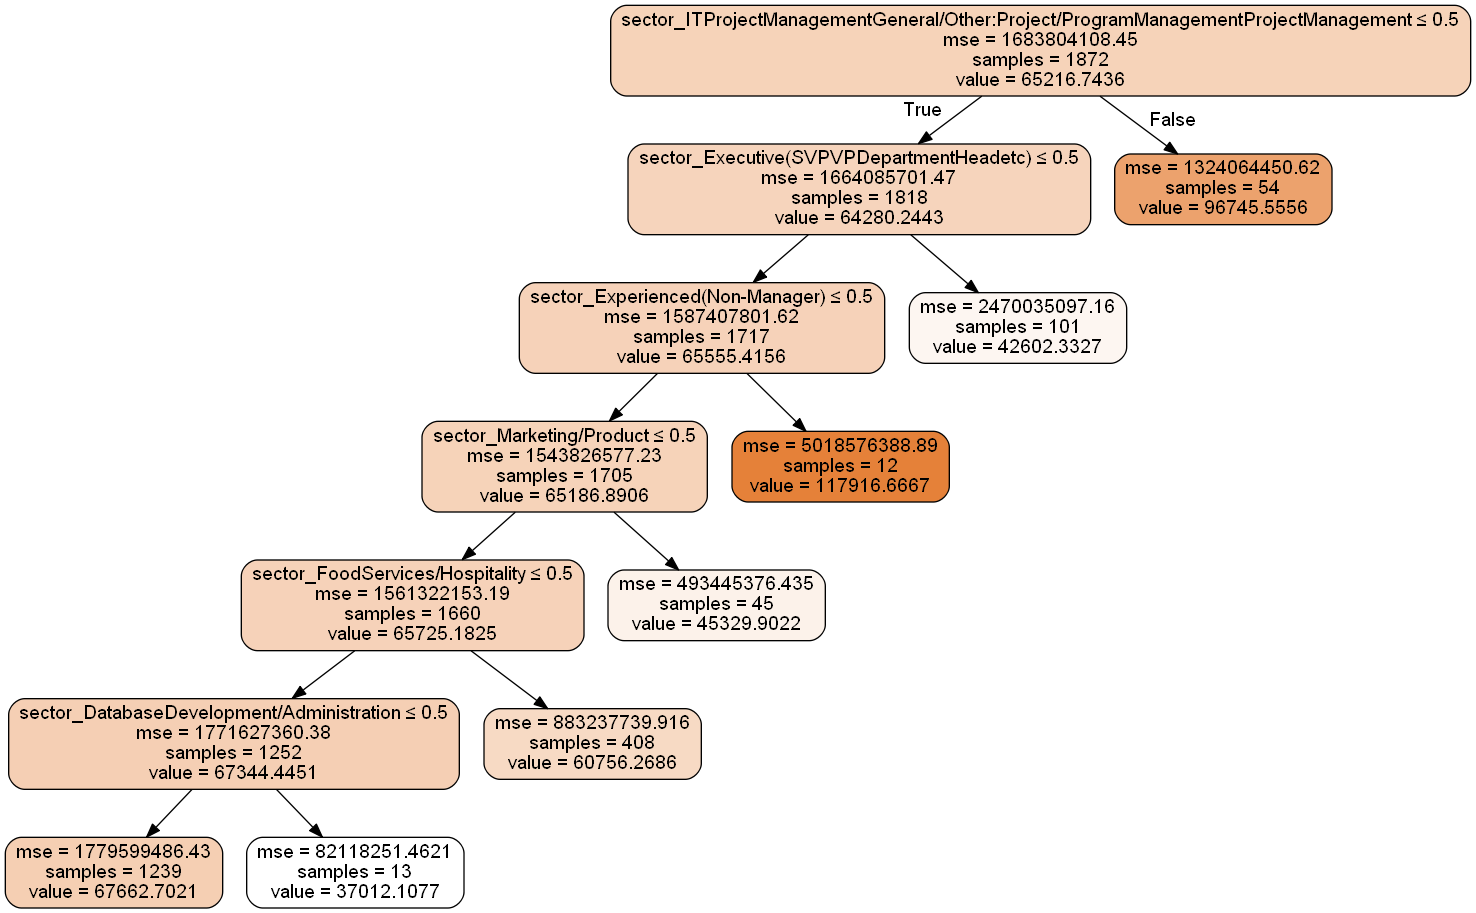

In [291]:
## Use a decision tree to look at what variables are most important
#use the same train/test split to run a decision tree
decision_tree = DecisionTreeRegressor(max_depth=6, random_state=1)
decision_tree.fit(X_train_1,y_train_1)
print("Decision Tree RMSE:",np.sqrt(metrics.mean_squared_error(y_test,decision_tree.predict(X_test_1))))

#This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

('Decision Tree Train/Test RMSE:', 45240.256558725654, ' ', 31247.032923509178)
('Decision Tree Train/Test RMSE:', 44934.319079039007, ' ', 30493.528125803139)
('Decision Tree Train/Test RMSE:', 44617.231784894451, ' ', 30616.437832625652)
('Decision Tree Train/Test RMSE:', 44533.82310198911, ' ', 30283.972235108467)
('Decision Tree Train/Test RMSE:', 44461.204475527964, ' ', 30319.176039227936)
('Decision Tree Train/Test RMSE:', 44400.01241355003, ' ', 30223.082209499658)
('Decision Tree Train/Test RMSE:', 44341.222783604884, ' ', 30165.958222952668)
('Decision Tree Train/Test RMSE:', 44286.715491493742, ' ', 30152.519319521838)
('Decision Tree Train/Test RMSE:', 44235.820462178628, ' ', 30108.143957489814)


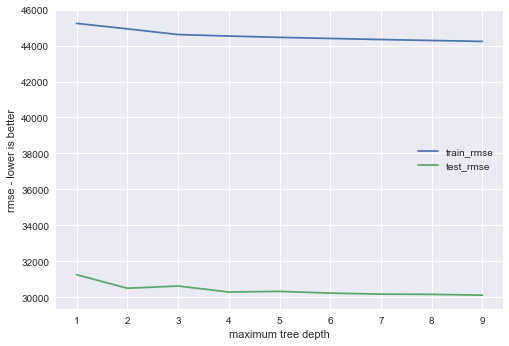

In [282]:
depths = range(1,10)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(metrics.mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(metrics.mean_squared_error(y_test,decision_tree.predict(X_test)))
    print("Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse)
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend()

The RMSE is several orders of magnitude lower when using decision trees as compared to linear regression. Therefore, it could be that it's a better fit for this dataset. However, the rmse is still pretty large. 

In [106]:
#remove ma
ma_data=data[data.state=='']

<bound method Series.unique of 13                               EntryLevel
14       BuildingConstruction/SkilledTrades
19                 Experienced(Non-Manager)
29                              Engineering
30                                      NaN
32                 Experienced(Non-Manager)
36                              Engineering
41                 Experienced(Non-Manager)
43                                      NaN
61       Manager(Manager/SupervisorofStaff)
64                 Experienced(Non-Manager)
68                 Experienced(Non-Manager)
80                                      NaN
82                                      NaN
83                 Experienced(Non-Manager)
88                                      NaN
100                Experienced(Non-Manager)
111                Experienced(Non-Manager)
117                Experienced(Non-Manager)
121                Experienced(Non-Manager)
127                                     NaN
134      Manager(Manager/SupervisorofStaff)
1

('Decision Tree RMSE:', 40895.124944687916)


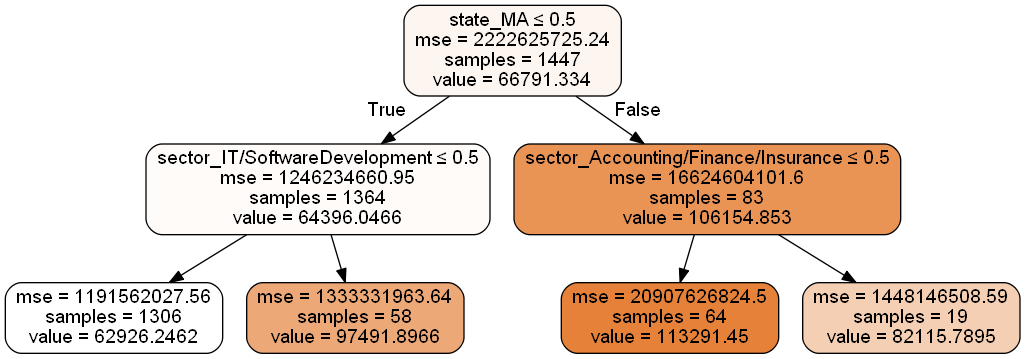

In [123]:
#remove the offending values from the dataset
data_cleaned=data[data.sector!='Experienced(Non-Manager)']
data_cleaned=data[data.sector!='Experienced(Non-Manager)']
#re-run the model

# Try the model using upper and lower ranges rather than midpoint
df3=pd.get_dummies(data_cleaned[['state','sector']],drop_first=True)


y2=data_cleaned['midpoint_salary']

# Split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df3,y2,test_size=.22)

decision_tree = DecisionTreeRegressor(max_depth=2, random_state=1)
decision_tree.fit(X_train,y_train)
print("Decision Tree RMSE:",np.sqrt(metrics.mean_squared_error(y_test,decision_tree.predict(X_test))))

#This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [32]:
data.ranges.unique

<bound method Series.unique of 13                  9.00 - 13.00 
14         80,000.00 - 95,000.00 
19         60,000.00 - 72,000.00 
29        70,000.00 - 100,000.00 
30                 62.00 - 81.00 
32        75,000.00 - 100,000.00 
36         68,000.00 - 72,000.00 
41         58,000.00 - 65,000.00 
43                 15.00 - 16.00 
61        45,000.00 - 100,000.00 
64         40,000.00 - 50,000.00 
68                 13.75 - 16.75 
80                 40.00 - 50.00 
82         80,000.00 - 90,000.00 
83         35,000.00 - 45,000.00 
88        80,000.00 - 100,000.00 
100        31,000.00 - 33,000.00 
111                50.00 - 65.00 
117      100,000.00 - 120,000.00 
121                17.00 - 22.00 
127       75,000.00 - 100,000.00 
134        56,000.00 - 64,000.00 
136                45.00 - 50.00 
137                25.00 - 27.00 
146       75,000.00 - 130,000.00 
182       60,000.00 - 110,000.00 
190       50,000.00 - 100,000.00 
201                12.00 - 12.00 
204        70,000